In [1]:
import sys

# Add the directory containing fs.py to the Python path
sys.path.append('./modules')

# Assuming FuzzySystemLayer and create_fuzzy_model are defined in fs.py
from fs import FuzzySystemLayer, create_fuzzy_model


/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Paths to the prepped data files
base_path = './daily_data/'  # Adjusted base path to where our files are now
X_train_path = base_path + 'X_train.csv'
X_test_path = base_path + 'X_test.csv'
y_train_path = base_path + 'y_train.csv'
y_test_path = base_path + 'y_test.csv'

# Loading the datasets
X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

# Impute missing values in 'value' and 'classification_numerical' columns
imputer = SimpleImputer(strategy='mean')
X_train[['value', 'classification_numerical']] = imputer.fit_transform(X_train[['value', 'classification_numerical']])

# Verify that there are no NaN values left
print("NaN values in X_train after imputation:\n", X_train.isna().sum().sum())

# Check for extreme values in the data
print("Extreme values in X_train:", (X_train > 1e9).sum().sum())

# Exclude non-numerical columns before scaling
columns_to_scale = X_train.columns  # All columns in X_train are numerical

# Initialize the scaler for the features
scaler_X = MinMaxScaler()

# Scale 'X' features
X_train_scaled = scaler_X.fit_transform(X_train[columns_to_scale])
X_test_scaled = scaler_X.transform(X_test[columns_to_scale])

# Initialize a separate scaler for the target variable
scaler_y = MinMaxScaler()

# Scale 'y' (the target variable)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


NaN values in X_train after imputation:
 0
Extreme values in X_train: 2367


## Function to Save Models

In [5]:
import os
import pickle
from datetime import datetime

def save_model_and_scalers(model, scaler_X, scaler_y, model_type):
    """
    Save the Keras model and scalers with a timestamp and type in a directory using pickle.

    Parameters:
    - model: The trained Keras model to be saved.
    - scaler_X: The MinMaxScaler object for the features.
    - scaler_y: The MinMaxScaler object for the target variable.
    - model_type: A string representing the type of the model (e.g., "RNN", "LSTM").
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = f"saved_models/{model_type}"  # Create a directory with the model name
    os.makedirs(save_dir, exist_ok=True)

    # Save the model
    model_filename = f"{save_dir}/{model_type}_model_{timestamp}.h5"
    model.save(model_filename)

    # Save the scalers
    scalers_filename = f"{save_dir}/{model_type}_scalers_{timestamp}.pkl"
    with open(scalers_filename, 'wb') as f:
        pickle.dump({'scaler_X': scaler_X, 'scaler_y': scaler_y}, f)

    print(f"Model saved to {model_filename}")
    print(f"Scalers saved to {scalers_filename}")

In [3]:
# Example: Using KMeans for finding cluster centers
from sklearn.cluster import KMeans

In [10]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
# Assuming FS_Regressor has been imported from the fs module


# Determine the optimal number of clusters (e.g., using domain knowledge, elbow method, etc.)
n_clusters = 3  # This is a placeholder; adjust based on our analysis

# Steps for cluster determination remain the same
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train_scaled)
cluster_centers = kmeans.cluster_centers_

# Define and train the TensorFlow-based model
model = create_fuzzy_model(input_dim=X_train_scaled.shape[1], cluster_centers=cluster_centers)
model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2)

# Save the model and scalers after training
save_model_and_scalers(model, scaler_X, scaler_y, "Fuzzy_basic")

# Predict and evaluate
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# MSE, RMSE, and MAPE calculation
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
y_test_original = y_test.values.flatten()
mape_test = np.mean(np.abs((y_test_original - y_pred) / y_test_original)) * 100

print(f"Mean Squared Error (MSE) on Test Set: {mse_test}")
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")
print(f"Mean Absolute Percentage Error (MAPE) on Test Set: {mape_test}%")

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 0.0238 - val_loss: 0.4049
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 0.0151 - val_loss: 0.3539
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 0.0130 - val_loss: 0.3135
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 0.0108 - val_loss: 0.2801
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 0.0087 - val_loss: 0.2513
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.0084 - val_loss: 0.2243
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 0.0070 - val_loss: 0.2028
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 0.0075 - val_loss: 0.1818
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 0.0065 - val_loss: 0.1633
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 0.0062 - val_loss: 0.1462
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 0.0062 - val_loss: 0.1313
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0

Model saved to saved_models/Fuzzy_basic/Fuzzy_basic_model_20240602_003146.h5
Scalers saved to saved_models/Fuzzy_basic/Fuzzy_basic_scalers_20240602_003146.pkl
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
Mean Squared Error (MSE) on Test Set: 393578084.6318453
Root Mean Squared Error (RMSE) on Test Set: 19838.802499945537
Mean Absolute Percentage Error (MAPE) on Test Set: 62.57161603423129%


In [11]:
import pandas as pd

# Recreate the datetime column from the index (assuming the index was a datetime index)
if 'datetime' not in X_test.columns:
    X_test['datetime'] = pd.to_datetime(X_test.index)

print("Available columns in X_test after adding datetime:", X_test.columns)


Available columns in X_test after adding datetime: Index(['open', 'volume', 'sma_30', 'rsi', 'macd', 'dia_close', 'dia_volume',
       'gld_close', 'gld_volume', 'spy_close', 'spy_volume',
       'federal_funds_rate_daily', 'treasury_yield_daily', 'cpi_monthly',
       'durables_monthly', 'nonfarm_payroll_monthly',
       'real_gdp_per_capita_quarterly', 'real_gdp_quarterly',
       'retail_sales_monthly', 'unemployment_monthly',
       'central_bank_policy_rate_prcnt', 'domestic_credit_gdp',
       'foreign_direct_investment_value', 'gdp_growth_annual_prcnt',
       'inflation_rate_value',
       'individuals_using_the_internet_prcnt_of_population',
       'mobile_cellular_subscriptions_per_100_people',
       'personal_remittances_received_prcnt_of_gdp',
       'stock_market_index_value', 'tariffs_value',
       'total_public_debt_gdp_value', 'trade_balance_value',
       'trade_in_services_value', 'unemployment_rate_value', 'value',
       'classification_numerical', 'datetime'],
  

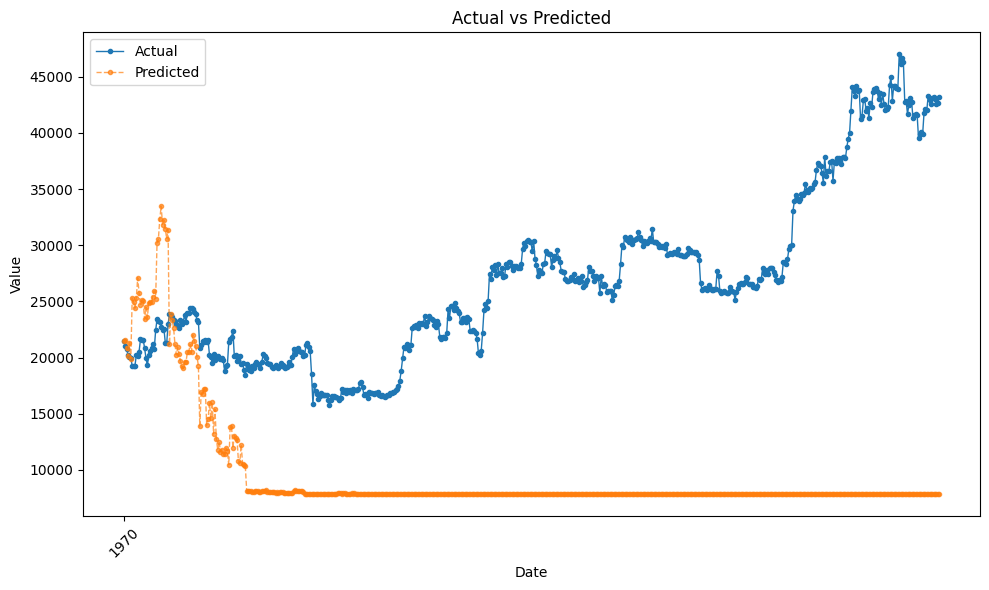

In [12]:
import matplotlib.pyplot as plt
y_test_original = y_test.values.flatten()[:len(y_pred)]  # Adjust length if necessary
# Assuming y_test_original and y_pred are correctly aligned with these dates
test_dates_aligned = X_test['datetime'].values[-len(y_pred):]

plt.figure(figsize=(10, 6))
plt.plot(test_dates_aligned, y_test_original, label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(test_dates_aligned, y_pred, label='Predicted', alpha=0.7, marker='.', linestyle='--', linewidth=1)
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Improve readability of the date labels
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
